# Imports

Following this tutorial for using kaggle with colab: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html.

Following this tutorial for the data processing and DCGAN: https://towardsdatascience.com/dcgans-generating-dog-images-with-tensorflow-and-keras-fb51a1071432

Repo for above ^ tutorial: https://github.com/JadeBlue96/DCGAN-Dog-Generator.git

Also following this tutorial for the DCGAN: https://www.tensorflow.org/tutorials/generative/dcgan

In [ ]:
#!pip install keras==2.3.1 # https://stackoverflow.com/questions/63062833/no-module-named-keras-legacy?scrlybrkr
#!pip install tensorflow==2.1.0 # https://stackoverflow.com/questions/61137954/attributeerror-module-tensorflow-python-keras-utils-generic-utils-has-no-attr

In [1]:
!pip install kaggle # will be using the stanford dogs dataset with kaggle 

In [2]:
from google.colab import drive # to save images and checkpoints to google drive
drive.mount('/content/drive', force_remount=True)

import numpy as np # for np arrays
import matplotlib.pyplot as plt, zipfile # creating plots

from pathlib import Path # directories as OOP
import os # file reading
import xml.etree.ElementTree as ET # for parsing annotations 
import cv2 # for reading the image

import math
import random

import time
import datetime

from tqdm import tqdm, tqdm_notebook # progress bar

import tensorflow as tf # for the model

import json # for keras api key

Mounted at /content/drive


# Setting up Keras

In [3]:
!ls -a

.  ..  .config	drive  sample_data


In [4]:
!mkdir .kaggle
!ls -a

.  ..  .config	drive  .kaggle	sample_data


In [5]:
username = "theenquirer"
api_key = "7d7171fcfbb1c06716445d9838fffbb8" # yes I know this shouldn't be in the repo


token = {"username": username,"key": api_key} # secret

with open('/content/.kaggle/kaggle.json', 'w') as file:
  json.dump(token, file)

In [ ]:
!chmod 600 /content/.kaggle/kaggle.json # read + write allowed

In [9]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [10]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [11]:
!kaggle datasets download fournierp/captcha-version-2-images -p /content # download stanford dog dataset

 29% 5.00M/17.4M [00:00<00:00, 29.2MB/s]
100% 17.4M/17.4M [00:00<00:00, 69.2MB/s]


# Data Preparation

In [12]:
!unzip \*.zip # unzip dataset

Archive:  captcha-version-2-images.zip
  inflating: samples/226md.png       
  inflating: samples/22d5n.png       
  inflating: samples/2356g.png       
  inflating: samples/23mdg.png       
  inflating: samples/23n88.png       
  inflating: samples/243mm.png       
  inflating: samples/244e2.png       
  inflating: samples/245y5.png       
  inflating: samples/24f6w.png       
  inflating: samples/24pew.png       
  inflating: samples/25257.png       
  inflating: samples/253dc.png       
  inflating: samples/25egp.png       
  inflating: samples/25m6p.png       
  inflating: samples/25p2m.png       
  inflating: samples/25w53.png       
  inflating: samples/264m5.png       
  inflating: samples/268g2.png       
  inflating: samples/28348.png       
  inflating: samples/28x47.png       
  inflating: samples/2b827.png       
  inflating: samples/2bg48.png       
  inflating: samples/2cegf.png       
  inflating: samples/2cg58.png       
  inflating: samples/2cgyx.png       
  inflating

In [ ]:
!ls -a
# !ls -a samples
!pwd

.   captcha-version-2-images.zip  drive    sample_data
..  .config			  .kaggle  samples
/content


In [242]:
img_width = 64 # width we will be resizing images to
img_height = 64 # height we will be resizing images to
img_color_channels = 3 # rgb
img_sample_size = 10000
img_output_dir = '/output_images/'
img_input_dir = '/content/samples/'
img_ann_dir = "/content/Annotation/"
OUT_DIR = Path('/output_images/')
TRAIN_DIR = Path('/content/samples')

In [243]:
dog_breed_dict = {}
# for annotation in os.listdir(img_ann_dir):
#   # annotations follow the format:
#   # image_name-breed_name
#   annotations = annotation.split('-')
#   dog_breed_dict[annotations[0]] = annotations[1]

In [244]:
print(dog_breed_dict)

{}


In [245]:
def read_image(img_path):
  '''Reads and transforms an image to RGB.'''
  img = cv2.imread(img_path)
  if img is None:
    raise FileNotFoundError
  else: # technically unnecessary else statement
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

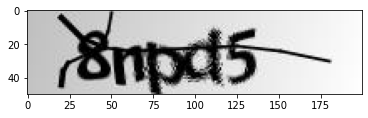

In [246]:
# print(os.listdir(img_input_dir))
for dog_ann in os.listdir(img_input_dir)[:100]:
  # print(os.path.join(img_input_dir, dog_ann))
  try:
    img = read_image(os.path.join(img_input_dir, dog_ann)) # read image
    plt.imshow(img)
    # print("happening")
  except FileNotFoundError:
    continue



In [247]:
def load_cropped_images(dog_breed_dict=dog_breed_dict, img_ann_dir=img_ann_dir, sample_size=25000, img_width=img_width, img_height=img_height, img_channels=img_color_channels):
  """
  Loads all the dog images, crops, and resizes them.
  This is the bulk of where the data processing occurs.
  """
  i = 0 # indexing variable
  breeds = []
  # sample size is the number of dogs
  dog_images_np = np.zeros((sample_size, img_width, img_height, img_channels))
  for breed_folder in os.listdir(img_ann_dir):
    for dog_ann in tqdm(os.listdir(img_ann_dir + breed_folder)):
      try:
        img = read_image(os.path.join(img_input_dir, dog_ann + '.jpg')) # read image
      except FileNotFoundError:
        continue
                
      tree = ET.parse(os.path.join(img_ann_dir + breed_folder, dog_ann)) # get the annotations for this image
      root = tree.getroot()
            
      size = root.find('size')
      width = int(size.find('width').text)
      height = int(size.find('height').text)
      objects = root.findall('object')

      for dog in objects: # some images contain multiple dogs, hence objects plural
        bndbox = dog.find('bndbox') # the bounding box around the dog
                
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
                
        xmin = max(0, xmin - 4) # add a margin of 4
        xmax = min(width, xmax + 4) # add a margin of 4
        ymin = max(0, ymin - 4) # add a margin of 4
        ymax = min(height, ymax + 4) # add a margin of 4

        # I am honestly unsure why we are adding a margin of 4, but that is what the code I am following does

        w = np.min((xmax - xmin, ymax - ymin)) # we are cropping these to squares, so we want to use the smaller dimension
        w = min(w, width, height) # this is just to be safe (perhaps the bounding box extends past the image)

        if w > xmax - xmin:
          xmin = min(max(0, xmin - int((w - (xmax - xmin))/2)), width - w)
          xmax = xmin + w
        if w > ymax - ymin:
          ymin = min(max(0, ymin - int((w - (ymax - ymin))/2)), height - w)
          ymax = ymin + w
        
        img_cropped = img[ymin:ymin+w, xmin:xmin+w, :] # [h,w,c]

        # all of the above was to crop the image to just include the dog
        # below is to resize the image to the dimensions we want (img_width and img_height)

        # determine interpolation method
        if xmax - xmin > img_width:
            interpolation = cv2.INTER_AREA # we need to shrink
        else:
            interpolation = cv2.INTER_CUBIC # we need to expand
            
        img_resized = cv2.resize(img_cropped, (img_width, img_height), 
                                interpolation=interpolation) # resize image
            
        dog_images_np[i,:,:,:] = np.asarray(img_resized)
        # annotations follow the format:
        # image_name-breed_name
        dog_breed_name = dog_breed_dict[dog_ann.split('_')[0]] # get the breed name using the image name
        breeds.append(dog_breed_name)
        i += 1
                
  return dog_images_np, breeds

In [248]:
def mload_cropped_images(dog_breed_dict=dog_breed_dict, img_ann_dir=img_ann_dir, sample_size=25000, img_width=img_width, img_height=img_height, img_channels=img_color_channels):
  """
  Loads all the dog images, crops, and resizes them.
  This is the bulk of where the data processing occurs.
  """
  i = 0 # indexing variable
  breeds = []
  # sample size is the number of dogs
  dog_images_np = np.zeros((sample_size, img_width, img_height, img_channels))
  # for breed_folder in os.listdir(img_ann_dir):
  # for dog_ann in tqdm(os.listdir(img_input_dir)):
  #   try:
  #     img = read_image(os.path.join(img_input_dir, dog_ann + '.png')) # read image
  #   except FileNotFoundError:
  #     continue
  for dog_ann in os.listdir(img_input_dir):
    # print(os.path.join(img_input_dir, dog_ann))
    try:
      img = read_image(os.path.join(img_input_dir, dog_ann)) # read image
      # plt.imshow(img)
      # print("happening")
    except FileNotFoundError:
      continue
              
    # tree = ET.parse(os.path.join(img_ann_dir + breed_folder, dog_ann)) # get the annotations for this image
    # root = tree.getroot()
          
    # size = root.find('size')
    # width = int(size.find('width').text)
    # height = int(size.find('height').text)
    # objects = root.findall('object')

    # for dog in objects: # some images contain multiple dogs, hence objects plural
    #   bndbox = dog.find('bndbox') # the bounding box around the dog
              
    #   xmin = int(bndbox.find('xmin').text)
    #   ymin = int(bndbox.find('ymin').text)
    #   xmax = int(bndbox.find('xmax').text)
    #   ymax = int(bndbox.find('ymax').text)
              
    #   xmin = max(0, xmin - 4) # add a margin of 4
    #   xmax = min(width, xmax + 4) # add a margin of 4
    #   ymin = max(0, ymin - 4) # add a margin of 4
    #   ymax = min(height, ymax + 4) # add a margin of 4

    #   # I am honestly unsure why we are adding a margin of 4, but that is what the code I am following does

    #   w = np.min((xmax - xmin, ymax - ymin)) # we are cropping these to squares, so we want to use the smaller dimension
    #   w = min(w, width, height) # this is just to be safe (perhaps the bounding box extends past the image)

    #   if w > xmax - xmin:
    #     xmin = min(max(0, xmin - int((w - (xmax - xmin))/2)), width - w)
    #     xmax = xmin + w
    #   if w > ymax - ymin:
    #     ymin = min(max(0, ymin - int((w - (ymax - ymin))/2)), height - w)
    #     ymax = ymin + w
      
    #   img_cropped = img[ymin:ymin+w, xmin:xmin+w, :] # [h,w,c]

    # all of the above was to crop the image to just include the dog
    # below is to resize the image to the dimensions we want (img_width and img_height)

    # determine interpolation method
    # if xmax - xmin > img_width:
    # interpolation = cv2.INTER_AREA # we need to shrink
    # else:
    interpolation = cv2.INTER_CUBIC # we need to expand
        
    img_resized = cv2.resize(img, (64, 64), 
                            interpolation=interpolation) # resize image
        
    # dog_images_np[i,:,:,:] = np.asarray(img_resized)
    dog_images_np[i,:,:,:] = np.asarray(img_resized)

    # annotations follow the format:
    # image_name-breed_name
    # dog_breed_name = dog_breed_dict[dog_ann.split('_')[0]] # get the breed name using the image name
    # breeds.append(dog_breed_name)
    i += 1
                
  return dog_images_np, breeds

In [249]:
start = time.time()
breeds = []
# the person who did this originally found there to be exactly 22125 dogs
# which helps in creating our np array of fixed size
print("LOADING IMAGES...")
dog_images_np, breeds = mload_cropped_images(sample_size=1070)
# dog_images_np is the input data, breeds are the labels we are trying to predict
rounded_time = time.time() - start
print(f"\nImage loading, cropping, and resizing time: {datetime.timedelta(seconds=rounded_time)}.")

LOADING IMAGES...

Image loading, cropping, and resizing time: 0:00:00.323498.


In [250]:
def plot_features(features, labels, img_width=img_width, img_height=img_height, img_channels=img_color_channels, examples=16, disp_labels=True): 
  """Plots some dog images and their corresponding breeds."""
  if not math.sqrt(examples).is_integer():
    print('Please select a valid number of examples (must be a perfect square).')
    return
  imgs = []
  classes = []
  for i in range(examples):
    rnd_idx = np.random.randint(0, len(labels))
    imgs.append(features[rnd_idx, :, :, :])
    classes.append(labels[rnd_idx])

  fig, axes = plt.subplots(round(math.sqrt(examples)), round(math.sqrt(examples)), figsize=(15,15),
  subplot_kw = {'xticks':[], 'yticks':[]},
  gridspec_kw = dict(hspace=0.3, wspace=0.01))
    
  for i, ax in enumerate(axes.flat):
    if disp_labels == True:
      ax.title.set_text(classes[i])
    ax.imshow(imgs[i])

In [251]:
def mplot_features(features, labels, img_width=img_width, img_height=img_height, img_channels=img_color_channels, examples=16, disp_labels=True): 
  """Plots some dog images and their corresponding breeds."""
  if not math.sqrt(examples).is_integer():
    print('Please select a valid number of examples (must be a perfect square).')
    return
  imgs = []
  classes = []
  for i in range(examples):
    rnd_idx = np.random.randint(0, len(labels))
    imgs.append(features[rnd_idx, :, :, :])
    classes.append(labels[rnd_idx])

  fig, axes = plt.subplots(round(math.sqrt(examples)), round(math.sqrt(examples)), figsize=(15,15),
  subplot_kw = {'xticks':[], 'yticks':[]},
  gridspec_kw = dict(hspace=0.3, wspace=0.01))
    
  for i, ax in enumerate(axes.flat):
    if disp_labels == True:
      ax.title.set_text(classes[i])
    ax.imshow(imgs[i])

In [252]:
print(dog_images_np)

[[[[192. 192. 192.]
   [193. 193. 193.]
   [194. 194. 194.]
   ...
   [249. 249. 249.]
   [250. 250. 250.]
   [251. 251. 251.]]

  [[192. 192. 192.]
   [193. 193. 193.]
   [194. 194. 194.]
   ...
   [249. 249. 249.]
   [250. 250. 250.]
   [251. 251. 251.]]

  [[192. 192. 192.]
   [193. 193. 193.]
   [194. 194. 194.]
   ...
   [249. 249. 249.]
   [250. 250. 250.]
   [251. 251. 251.]]

  ...

  [[195. 195. 195.]
   [196. 196. 196.]
   [197. 197. 197.]
   ...
   [252. 252. 252.]
   [253. 253. 253.]
   [254. 254. 254.]]

  [[195. 195. 195.]
   [196. 196. 196.]
   [197. 197. 197.]
   ...
   [252. 252. 252.]
   [253. 253. 253.]
   [254. 254. 254.]]

  [[195. 195. 195.]
   [196. 196. 196.]
   [197. 197. 197.]
   ...
   [252. 252. 252.]
   [253. 253. 253.]
   [254. 254. 254.]]]


 [[[192. 192. 192.]
   [193. 193. 193.]
   [194. 194. 194.]
   ...
   [249. 249. 249.]
   [250. 250. 250.]
   [251. 251. 251.]]

  [[192. 192. 192.]
   [193. 193. 193.]
   [194. 194. 194.]
   ...
   [249. 249. 249.]
 

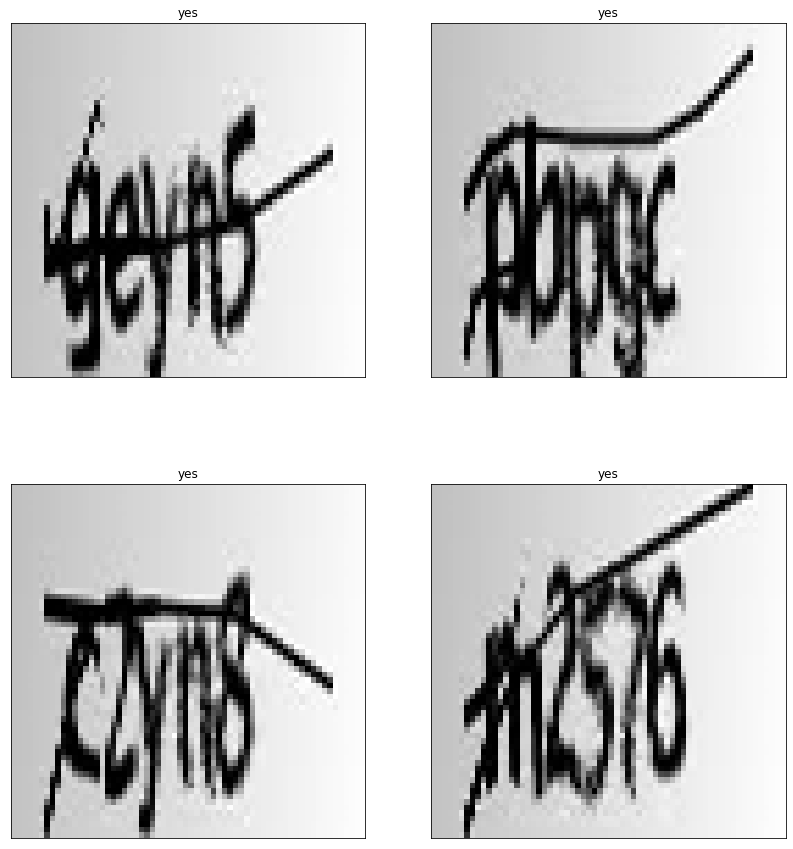

In [253]:
fbreeds = ["yes"] * 16
mplot_features(dog_images_np / 255., fbreeds, examples=4, disp_labels=True)

# NOTE: dog_images_np / 255. normalizes the pixel range to [0, 1]

# Something else to note is that because we are cropping the images into squares,
# sometimes we only get part of the dog,
# like only the body of the whippet below

In [254]:
sample_size = 1070
batch_size = 128

dog_images_np = (dog_images_np - (255/2)) / (255/2)  # normalize the pixel range to [-1, 1], because I will be using tanh for my output, which has the range [-1, 1]

dog_features_tf = tf.cast(dog_images_np, 'float32') # create tf dataset object

# some data augmentation
def flip(x: tf.Tensor) -> (tf.Tensor):
    # x = tf.image.random_flip_left_right(x) # 50% img will be flipped
    return x

# shuffle, flip 50% of images, and separate into batches
dog_features_data = tf.data.Dataset.from_tensor_slices(dog_features_tf).shuffle(sample_size).map(flip).batch(batch_size, drop_remainder=True)


In [255]:
print(dog_features_data)

<BatchDataset shapes: (128, 64, 64, 3), types: tf.float32>


# Model Building

In [256]:
# Necessary tf imports

from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Reshape,\
Conv2DTranspose, Conv2D, Flatten, Dropout, Embedding, ReLU, Conv2DTranspose
from tensorflow.keras.optimizers import Adam

In [257]:
# a bunch of hyperparameters that were pretuned (some of these are for the generator, some for the descriminator)

sample_size = 1070 # number of images
batch_size = 128

weight_init_std = 0.02 # for "stabalizing model training"
weight_init_mean = 0.0 # for "stabalizing model training"

leaky_relu_slope = 0.2

dropout_rate = 0.5

downsize_factor = 2
scale_factor = 4 ** downsize_factor # reshapes generator's noise vector to (4, 4, 512)

# params for learning rate
lr_initial_d = tf.Variable(0.0002)
lr_initial_g = tf.Variable(0.0002)
lr_decay_steps = 1000

noise_dim = 128

In [258]:
weight_initializer = tf.keras.initializers.TruncatedNormal(stddev=weight_init_std, mean=weight_init_mean, seed=42)

In [259]:
# Template layers so I don't have to keep on rewriting the same code.

# for the generator
def transposed_conv(model, out_channels, kernel_size, stride_size, ptype='same'):
    model.add(Conv2DTranspose(out_channels, (kernel_size, kernel_size), 
                              strides=(stride_size, stride_size), 
                              padding=ptype, kernel_initializer=weight_initializer, use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    return model

# for the discriminator
def conv(model, out_channels, ksize, stride_size):
    model.add(Conv2D(out_channels, (ksize, ksize), strides=(stride_size, stride_size), padding='same', 
                     kernel_initializer=weight_initializer, use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=leaky_relu_slope))
    model.add(Dropout(dropout_rate))
    return model

In [260]:
def WoofGenerator():
  # img_height = 256
  # img_width = 256
  model = Sequential()
  print(img_width // scale_factor * img_height // scale_factor * 128)
  # print(img_color_channels)
  print(img_width // scale_factor)

  model.add(Dense(img_width // scale_factor * img_height // scale_factor * 128,
                  input_shape=(noise_dim,),
                  kernel_initializer=weight_initializer))

  # model.add(Dense(64 // scale_factor * 64 // scale_factor * 128,
  #                 input_shape=(noise_dim,),
  #                 kernel_initializer=weight_initializer))
  # model.add(Flatten())

  model.add(Reshape((img_height // scale_factor, img_width // scale_factor, 128)))
  
  # using the helper functions
  model = transposed_conv(model, 512, kernel_size=5, stride_size=1)
  model = transposed_conv(model, 256, kernel_size=5, stride_size=2)
  model = transposed_conv(model, 128, kernel_size=5, stride_size=2)
  model = transposed_conv(model, 64, kernel_size=5, stride_size=2)
  model = transposed_conv(model, 32, kernel_size=5, stride_size=2)
  
  model.add(Dense(img_color_channels, activation='tanh', kernel_initializer=weight_initializer))
  
  return model

In [261]:
dog_generator = WoofGenerator()
print(dog_generator.summary())

2048
4
Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_65 (Dense)             (None, 2048)              264192    
_________________________________________________________________
reshape_44 (Reshape)         (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_transpose_90 (Conv2DT (None, 4, 4, 512)         1638400   
_________________________________________________________________
batch_normalization_96 (Batc (None, 4, 4, 512)         2048      
_________________________________________________________________
leaky_re_lu_98 (LeakyReLU)   (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_91 (Conv2DT (None, 8, 8, 256)         3276800   
_________________________________________________________________
batch_normalization_97 (Batc (None, 8, 8, 256)

Just as a sanity check, it makes sense that the final output has the dimensions (None, 64, 64, 3), because we are generating images of dimensions 64x64 and the 3 channels for RGB.

In [262]:
def WoofDiscriminator():
  model = Sequential()

  model.add(Conv2D(64, (4, 4), strides=(2,2), padding='same', use_bias=False, 
                   input_shape=[img_height, img_width, img_color_channels],  
                   kernel_initializer=weight_initializer))
  model.add(LeakyReLU(alpha=leaky_relu_slope))

  # using the helper functions
  model = conv(model, 64, ksize=4, stride_size=2)
  model = conv(model, 128, ksize=4, stride_size=2)
  model = conv(model, 256, ksize=4, stride_size=2)

  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))
  return model

In [263]:
dog_discriminator = WoofDiscriminator()
print(dog_discriminator.summary())

Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 32, 64)        3072      
_________________________________________________________________
leaky_re_lu_103 (LeakyReLU)  (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 64)        65536     
_________________________________________________________________
batch_normalization_101 (Bat (None, 16, 16, 64)        256       
_________________________________________________________________
leaky_re_lu_104 (LeakyReLU)  (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 8, 8, 128)       

Just as a sanity check, it makes sense that the final output has the dimensions (None, 1), because the descriminator is a binary classifier.

In [264]:
generator_optimizer = Adam(learning_rate=lr_initial_g, beta_1=0.5)
discriminator_optimizer = Adam(learning_rate=lr_initial_d, beta_1=0.5)

In [265]:
# Helper function for loss functions in next cell

def smooth_positive_labels(y):
  """1 --> [0.7, 1.0]"""
  return y - (np.random.random(y.shape) * 0.3)

def smooth_negative_labels(y):
  """0 --> [0.0, 0.3]"""
  return y + (np.random.random(y.shape) * 0.3)

def noisy_labels(y, p_flip):
  """Randomly flips some labels."""
  # determine the number of labels to flip
  n_select = int(p_flip * int(y.shape[0]))
  # choose labels to flip
  flip_ix = np.random.choice([i for i in range(int(y.shape[0]))], size=n_select)
    
  output_list = []
  for i in range(int(y.shape[0])):
    if i in flip_ix:
      output_list.append(tf.cast(tf.subtract(1, tf.cast(y[i], tf.int32)), tf.float32))
    else:
      output_list.append(y[i])
    
  outputs = tf.stack(output_list)
  return outputs

In [266]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def woof_generator_loss(fake_output):
  fake_output_smooth = smooth_negative_labels(tf.ones_like(fake_output)) # smooth labels
  return cross_entropy(tf.ones_like(fake_output_smooth), fake_output)

def woof_discriminator_loss(real_output, fake_output):

  # randomly flip some labels
  real_output_noise = noisy_labels(tf.ones_like(real_output), 0.05)
  fake_output_noise = noisy_labels(tf.zeros_like(fake_output), 0.05)
  # smooth labels
  real_output_smooth = smooth_positive_labels(real_output_noise)
  fake_output_smooth = smooth_negative_labels(fake_output_noise)
  
  real_loss = cross_entropy(tf.ones_like(real_output_smooth), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output_smooth), fake_output)
  return real_loss + fake_loss

In [306]:
# so I can save my model!
!mkdir drive/MyDrive
!mkdir drive/MyDrive/DOG_GAN/attempt_4
!mkdir drive/MyDrive/DOG_GAN/attempt_4/training_checkpoints
!mkdir drive/MyDrive/DOG_GAN/attempt_4/images

checkpoint_dir = 'drive/MyDrive/DOG_GAN/attempt_4/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer, 
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=dog_generator,
                                 discriminator=dog_discriminator)

mkdir: cannot create directory ‘drive/MyDrive’: File exists
mkdir: cannot create directory ‘drive/MyDrive/DOG_GAN/attempt_4’: File exists
mkdir: cannot create directory ‘drive/MyDrive/DOG_GAN/attempt_4/training_checkpoints’: File exists


In [268]:
EPOCHS = 280
num_examples_to_generate = 64
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Model Training

In [269]:
@tf.function
def train_step(images):
  noise = tf.random.normal([batch_size, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = dog_generator(noise, training=True)

    real_output = dog_discriminator(images, training=True)
    fake_output = dog_discriminator(generated_images, training=True)

    gen_loss = woof_generator_loss(fake_output)
    disc_loss = woof_discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, dog_generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, dog_discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, dog_generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, dog_discriminator.trainable_variables))

  return gen_loss, disc_loss

In [270]:
import glob
import imageio
import PIL
from IPython import display

def generate_and_save_images(model, epoch, test_input, rows=8, cols=8):
  predictions = model(test_input, training=False)
  fig = plt.figure(figsize=(14,14))
  for i in range(predictions.shape[0]):
    plt.subplot(rows, cols, i+1)
    plt.imshow((predictions[i, :, :, :] * 127.5 + 127.5) / 255.) # * (127.5 + 127.5) / 255 to normalize [0, 1]
    plt.axis('off') 
      
  plt.subplots_adjust(wspace=0, hspace=0)
  # plt.savefig('drive/MyDrive/DOG_GAN/attempt_4/images/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

def generate_test_image(model, noise_dim=noise_dim):
  test_input = tf.random.normal([1, noise_dim])
  prediction = model(test_input, training=False)
  fig = plt.figure(figsize=(5,5))
  plt.imshow((prediction[0, :, :, :] * 127.5 + 127.5) / 255.)
  plt.axis('off') 
  plt.show()

In [271]:
def plot_losses(G_losses, D_losses, all_gl, all_dl, epoch):
  plt.figure(figsize=(10,5))
  plt.title("Generator and Discriminator Loss - EPOCH {}".format(epoch))
  plt.plot(G_losses, label="G")
  plt.plot(D_losses, label="D")
  plt.xlabel("Iterations")
  plt.ylabel("Loss")
  plt.legend()
  ymax = plt.ylim()[1]
  plt.show()
  
  plt.figure(figsize=(10, 5))
  plt.plot(np.arange(len(all_gl)), all_gl, label='G')
  plt.plot(np.arange(len(all_dl)), all_dl, label='D')
  plt.legend()
  plt.title('All Time Loss')
  plt.show()

def plot_total_losses(all_gl, all_dl):
  plt.figure(figsize=(10, 5))
  plt.plot(np.arange(len(all_gl)), all_gl, label='G')
  plt.plot(np.arange(len(all_dl)), all_dl, label='D')
  plt.legend()
  plt.title('All Time Loss')
  # plt.savefig('drive/MyDrive/DOG_GAN/attempt_4/images/loss.png')
  plt.show()

In [272]:
replay_step = 50
decay_step = 50
display_results = 1

def train(dataset, epochs):
  """Where all the magic happens!"""
  
  all_gl = np.array([])
  all_dl = np.array([])
  exp_replay = []

  for epoch in tqdm(range(epochs)):

    start = time.time()
    new_lr_d = lr_initial_d
    new_lr_g = lr_initial_g
    G_loss = []
    D_loss = []
    global_step = 0

    # the actual training
    for img_batch in dataset:
      g_loss, d_loss = train_step(img_batch)
      global_step = global_step + 1
      G_loss.append(g_loss)
      D_loss.append(d_loss)
      all_gl = np.append(all_gl, np.array([G_loss]))
      all_dl = np.append(all_dl, np.array([D_loss]))

    # Experience replay
    generated_image = dog_generator(tf.random.normal([1, noise_dim]), training=False)
    exp_replay.append(generated_image)
    if len(exp_replay) == replay_step:
      print('Executing experience replay..')
      replay_images = np.array([p[0] for p in exp_replay])
      dog_discriminator(replay_images, training=True)
      exp_replay = [] 

    # Occasionally plot losses 
    if (epoch + 1) % display_results == 0 or epoch == 0:
      display.clear_output(wait=True)
      plot_losses(G_loss, D_loss, all_gl, all_dl, epoch + 1)

    # Cosine learning rate decay
    if (epoch + 1) % decay_step == 0:
      new_lr_d = tf.keras.optimizers.schedules.CosineDecay(new_lr_d, min(global_step, lr_decay_steps), lr_decay_steps)
      new_lr_g = tf.keras.optimizers.schedules.CosineDecay(new_lr_g, min(global_step, lr_decay_steps), lr_decay_steps)
      generator_optimizer = Adam(learning_rate=new_lr_d, beta_1=0.5)
      discriminator_optimizer = Adam(learning_rate=new_lr_g, beta_1=0.5)   

    # produce images for the GIF
    generate_and_save_images(dog_generator, epoch + 1, seed)

    # save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(dog_generator, epochs, seed)
  plot_total_losses(all_gl, all_dl)
  return all_gl, all_dl

In [273]:
#checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

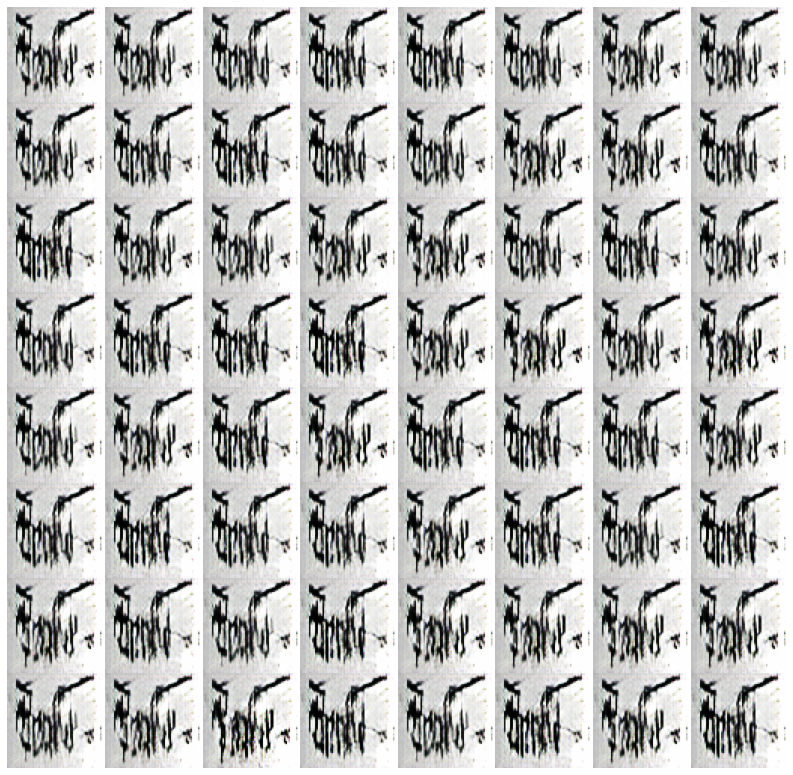

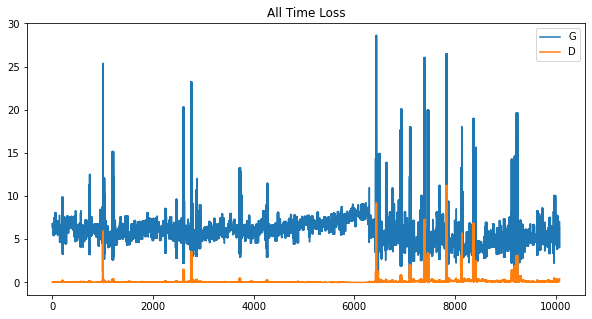

(array([6.82175779, 6.82175779, 6.30298281, ..., 4.52930498, 4.04281235,
        7.03599405]),
 array([0.01350868, 0.01350868, 0.01992508, ..., 0.22266906, 0.32411867,
        0.43189549]))

In [279]:
print("Let the magic begin!")

train(dog_features_data, EPOCHS)

tf.Tensor(
[[ 0.09515044 -0.10210096 -0.41324803  1.1810565  -0.0454472   0.11309455
  -0.21266983 -0.7844169   0.28475457  1.266038    0.3195556   1.4049053
  -0.3416919   0.09982257 -0.6067523  -0.263311    0.55928427  0.73327076
   0.36158168  0.32962814 -0.5419669   0.00747091  0.429102   -1.0250322
  -1.2124367  -1.3676299   0.19146006 -2.600661    0.57559526  0.25451788
   0.6599619   0.19418435 -0.1248853  -0.63168275 -0.19809566 -0.14437243
  -1.3037943   1.2193357  -1.3610513  -0.25176984  1.6077663  -0.3836302
   0.79568034  1.5612307  -0.09069948  0.17241861 -0.05361954 -0.4339541
  -0.3053582   0.76658136 -0.66122216 -0.5921011  -0.41073537 -0.7220965
  -0.19852778 -0.3408553   0.8099083  -1.7612998   1.2261767   2.5329309
   0.99290466 -0.32312292 -1.4462179   0.89489806  2.8152316  -1.2060852
  -0.5375745   2.0318096  -0.07243127  0.48363638 -0.5090623  -1.4400772
  -0.11016773 -1.1603781  -0.7396037  -0.66705555 -0.51315105  2.2030807
  -0.23380066  0.8138359  -0.0540571

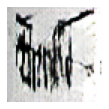

In [326]:
seed = tf.random.normal([1, noise_dim])
print(seed)
generate_and_save_images(dog_generator, EPOCHS, seed)

In [305]:
dog_discriminator.save_weights("model.h5")
dog_generator.save_weights("model.h5")

# Comments on Training Results

Generally, my training was not very successful.

The first time I attempted to train this,
the model simply did not generate dog images and had partial mode collapse. Additionally, although I did not track loss, I suspect that the model did not converge.

Here is the link to the gif of images generated by each epoch of this first attempt: [gif](https://drive.google.com/file/d/1MXDuEaEuUW3rIypuxaXwSIGKsiyUIF_0/view?usp=sharing).

After the first attempt, I implemented noisy labels, label smoothing, learning rate decay, and experience replay to attempt to remedy this. I attempted to train with these changes several times, and all but one ended up being cancelled (either by me or by colab timing out). 

Above, you can see the results of the final training attempt (which I am still training as I write this comment). The model still struggled with both converging and partial mode collapse, and produced splotchy images that mildly resembled dogs. I suspect exploding gradients may be one of the causes, as the generator seems to have trained in a very unstable manner.

Here is the link to the folder containing the images generated by this attempt: [folder](https://drive.google.com/drive/folders/1-6-P4x3KuY89HLp8vQK-RnCEKT-HLLmj?usp=sharing) (I do not yet have a GIF as I am still training this).

In [ ]:
def display_image(epoch_no):
  return Image.open('drive/MyDrive/DOG_GAN/attempt_4/images/image_at_epoch_{:04d}.png'.format(epoch_no))

display_image(EPOCHS-1) # display second to last epoch

In [ ]:
anim_file = 'drive/MyDrive/DOG_GAN/attempt_4/images/dog_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer: # create gif of an image for each epoch
  filenames = glob.glob('drive/MyDrive/DOG_GAN/attempt_4/images/image*.png') # get all of the images
  filenames = sorted(filenames) # sort by epoch num
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
!pip install git+https://github.com/tensorflow/docs

import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-ia5qmqp6
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-ia5qmqp6
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0ac1efa8e9d6e23ead09dde8757bae2e95a005ee2_-cp37-none-any.whl size=153530 sha256=62ba14e2337809819019c16025147c6b5eafc1aa526982d2acd35a5c68d45d7c
  Stored in directory: /tmp/pip-ephem-wheel-cache-w03rphge/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [ ]:
drive.flush_and_unmount()